In [30]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from transformers import AutoTokenizer, AutoModelForCausalLM
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from typing import Dict, List, Tuple, Any
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import matplotlib.pyplot as plt
import json
from tqdm import tqdm


In [8]:
from huggingface_hub import login
        
login(token= '')

In [14]:
model_id = "meta-llama/Llama-3.2-1B-Instruct"
dtype = torch.float16

tokenizer = AutoTokenizer.from_pretrained(model_id)
model = AutoModelForCausalLM.from_pretrained(
    model_id,
    device_map="auto",
    torch_dtype=dtype,
)


generation_config.json:   0%|          | 0.00/189 [00:00<?, ?B/s]

In [321]:
#df = pd.DataFrame()
#df['statement'] = ['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday']


#[f"{['morning', 'afternoon', 'evening', 'night'][i%4]} {['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday'][i//4%7]}" for i in range(28)]

#['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday']

#df['label'] = [0, 1, 2, 3, 4, 5, 6]

#[i//4 for i in range(28)]

color_map = {
    0:     '#FF6B6B',  # Coral red
    1:       '#4361EE',  # Royal blue
    2:    '#BA68C8',  # Purple
    3:       '#4ECDC4',  # Turquoise
    4:  '#FFB400',  # Golden yellow
    5:     '#FF8364',  # Salmon
    6:   '#2D6A4F'   # Forest green
}
label_names = {1: 'Monday', 2: 'Tuesday', 3: 'Wednesday', 4: 'Thursday', 5: 'Friday', 6: 'Saturday', 0: 'Sunday'}

df = pd.read_csv('daysofweek.csv')

In [323]:
def get_internal_activations(text):
    prompt = text
    inputs = tokenizer(prompt, return_tensors="pt").to(model.device)
    
    with torch.no_grad():
        outputs = model(**inputs, output_hidden_states =True)
    
    # Collect activations
    layer_activations = {}
    for i in range(len(outputs['hidden_states'])):
        layer_activations[f'model.layers.{i}.resid'] = outputs['hidden_states'][i]
    
    return layer_activations

def process_activations(df, text_column, n_samples, layers):
    activations_by_layer = {layer: [] for layer in layers}
    
    for sentence in tqdm(df[text_column][:n_samples], desc=f"Processing"):
        activations = get_internal_activations(sentence)
        for layer in layers:
            activations_by_layer[layer].append(activations[layer].detach().cpu().numpy()[0][-1])
    
    return {layer: np.array(acts) for layer, acts in activations_by_layer.items()}

In [325]:
# Usage
n_samples = 1300
text_column = 'statement'
label_column = 'label'
layers = ['model.layers.'+str(i)+'.resid' for i in range(16)]


# Process the pre-computed activations
activations_by_layer = process_activations(df[:n_samples], text_column, n_samples, layers)

Processing: 100%|█████████████████████████████| 105/105 [00:05<00:00, 17.62it/s]


In [327]:
layer = 'model.layers.4.resid'
layer_no = 4
activations = activations_by_layer[layer]

In [329]:
def patchify(
    model,
    tokenizer,
    source_prompt,
    target_prompt,
    source_token_index,
    source_layer_index,
    target_token_index,
    target_layer_index
):
    
    # Initialize source_activation as a list
    source_activation = []


    # Forward pass for prompt 1, collect activation at [source_token_index, source_layer_index]
    source_tokens = tokenizer(source_prompt, return_tensors="pt").to(model.device)

    layers = layers = model.model.layers

    outputs = model(**source_tokens, output_hidden_states=True)
    hidden_states = outputs['hidden_states']
    predicted_id = outputs[0].argmax(-1)[:, -1]
    source_tokens_output = tokenizer.decode(predicted_id.squeeze(0).tolist())
    
    print(hidden_states[0].shape)


    # Store the specific activation we want to patch
    source_activation_single = hidden_states[source_layer_index][0,source_token_index]
    def patch_hook(module, inp):
        nonlocal source_activation_single, target_token_index
        if inp[0].shape[1] > 1:
            inp[0][:,target_token_index] = source_activation_single
        return inp

    # Forward pass for prompt 2
    target_tokens = tokenizer(target_prompt, return_tensors="pt").to(model.device)
    outputs = model(**target_tokens, output_hidden_states=False, return_dict=False)
    predicted_id = outputs[0].argmax(-1)[:, -1]
    target_tokens_output = tokenizer.decode(predicted_id.squeeze(0).tolist())
    
    # Modified forward pass for prompt 2, patching activation at [target_token_index, target_layer_index]
    hook_p = layers[target_layer_index].register_forward_pre_hook(patch_hook)
    
    outputs = model.generate(**target_tokens, max_new_tokens=5)
    
    target_tokens_patched_output = tokenizer.decode(outputs[0,target_tokens['input_ids'].shape[1]:])

    #outputs = model(**target_tokens, output_hidden_states=False, return_dict=False)
    #predicted_id = outputs[0].argmax(-1)[:, -1]
    #target_tokens_patched_output = tokenizer.decode(predicted_id.squeeze(0).tolist())

    hook_p.remove()

    
    return source_tokens_output, target_tokens_output, target_tokens_patched_output

In [331]:
generations = []
for source_prompt in df['statement']:
    target_prompt = "Respond only with a single day of the week that is the completion to the identity pattern: Car -> Car, Book -> Book, x -> "
    target_prompt = "Repeat the day of the week here: x -> "

    source_token_index = -1
    target_token_index = -3

    source_layer_index = layer_no
    target_layer_index = layer_no
    
    _, _, response = patchify(
        model,
        tokenizer,
        source_prompt,
        target_prompt,
        source_token_index,
        source_layer_index,
        target_token_index,
        target_layer_index
    )
    
    generations.append(response)

pca = PCA(n_components=3, random_state=42)
acts_2d = pca.fit_transform(activations)[:,:2]

torch.Size([1, 7, 2048])


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


torch.Size([1, 7, 2048])


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


torch.Size([1, 7, 2048])


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


torch.Size([1, 7, 2048])


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


torch.Size([1, 7, 2048])


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


torch.Size([1, 7, 2048])
torch.Size([1, 7, 2048])


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


torch.Size([1, 7, 2048])
torch.Size([1, 7, 2048])


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


torch.Size([1, 7, 2048])


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


torch.Size([1, 7, 2048])


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


torch.Size([1, 7, 2048])


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


torch.Size([1, 7, 2048])


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


torch.Size([1, 7, 2048])


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


torch.Size([1, 7, 2048])


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


torch.Size([1, 7, 2048])


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


torch.Size([1, 7, 2048])


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


torch.Size([1, 7, 2048])


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


torch.Size([1, 7, 2048])


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


torch.Size([1, 7, 2048])


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


torch.Size([1, 7, 2048])


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


torch.Size([1, 7, 2048])


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


torch.Size([1, 7, 2048])


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


torch.Size([1, 7, 2048])


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


torch.Size([1, 7, 2048])


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


torch.Size([1, 7, 2048])


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


torch.Size([1, 7, 2048])


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


torch.Size([1, 7, 2048])


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


torch.Size([1, 7, 2048])


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


torch.Size([1, 7, 2048])


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


torch.Size([1, 7, 2048])


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


torch.Size([1, 7, 2048])


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


torch.Size([1, 8, 2048])
torch.Size([1, 7, 2048])


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


torch.Size([1, 7, 2048])
torch.Size([1, 7, 2048])


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


torch.Size([1, 7, 2048])


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


torch.Size([1, 7, 2048])


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


torch.Size([1, 7, 2048])


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


torch.Size([1, 7, 2048])


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


torch.Size([1, 7, 2048])


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


torch.Size([1, 7, 2048])


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


torch.Size([1, 7, 2048])
torch.Size([1, 7, 2048])


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


torch.Size([1, 7, 2048])
torch.Size([1, 7, 2048])


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


torch.Size([1, 7, 2048])
torch.Size([1, 7, 2048])


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


torch.Size([1, 7, 2048])
torch.Size([1, 7, 2048])


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


torch.Size([1, 7, 2048])
torch.Size([1, 7, 2048])


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


torch.Size([1, 7, 2048])


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


torch.Size([1, 7, 2048])


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


torch.Size([1, 7, 2048])


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


torch.Size([1, 7, 2048])


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


torch.Size([1, 7, 2048])


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


torch.Size([1, 7, 2048])


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


torch.Size([1, 7, 2048])
torch.Size([1, 7, 2048])


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


torch.Size([1, 7, 2048])


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


torch.Size([1, 7, 2048])


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


torch.Size([1, 7, 2048])
torch.Size([1, 7, 2048])


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


torch.Size([1, 7, 2048])


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


torch.Size([1, 7, 2048])


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


torch.Size([1, 7, 2048])


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


torch.Size([1, 7, 2048])


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


torch.Size([1, 7, 2048])


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


torch.Size([1, 7, 2048])


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


torch.Size([1, 7, 2048])


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


torch.Size([1, 7, 2048])


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


torch.Size([1, 7, 2048])
torch.Size([1, 7, 2048])


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


torch.Size([1, 7, 2048])


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


torch.Size([1, 7, 2048])


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


torch.Size([1, 7, 2048])
torch.Size([1, 7, 2048])


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


torch.Size([1, 7, 2048])


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


torch.Size([1, 7, 2048])


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


torch.Size([1, 7, 2048])


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


torch.Size([1, 7, 2048])


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


torch.Size([1, 7, 2048])


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


torch.Size([1, 7, 2048])


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


torch.Size([1, 7, 2048])


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


torch.Size([1, 7, 2048])


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


torch.Size([1, 7, 2048])


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


torch.Size([1, 7, 2048])


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


torch.Size([1, 7, 2048])


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


torch.Size([1, 7, 2048])


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


torch.Size([1, 7, 2048])


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


torch.Size([1, 7, 2048])


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


torch.Size([1, 7, 2048])


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


torch.Size([1, 7, 2048])


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


torch.Size([1, 7, 2048])


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


torch.Size([1, 7, 2048])


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


torch.Size([1, 7, 2048])


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


torch.Size([1, 7, 2048])


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


torch.Size([1, 7, 2048])


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


torch.Size([1, 7, 2048])
torch.Size([1, 7, 2048])


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


torch.Size([1, 7, 2048])


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


torch.Size([1, 7, 2048])


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


torch.Size([1, 7, 2048])


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


torch.Size([1, 7, 2048])


IndexError: list index out of range

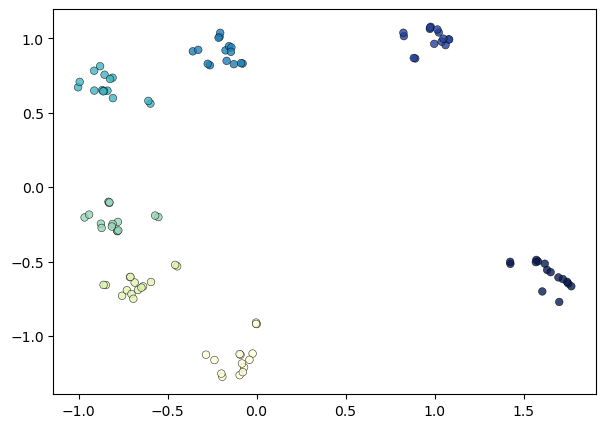

In [1020]:
def plot_pca_with_labels(acts_2d, generations, labels, figsize=(10, 8), fontsize=8, ):
    
    # Create figure and axis
    fig, ax = plt.subplots(figsize=figsize)
    
    # Plot scatter points
    ax.scatter(acts_2d[:, 0], acts_2d[:, 1], 
                                  #c = colors,
                                  c = labels, cmap = 'YlGnBu',
                                  #c=df[label_column][:n_samples].map(color_map), 
                                  alpha=0.8, s=30, edgecolor ='black', linewidth=0.4,)
        
    
    # Add text labels
    for i, (x, y) in enumerate(acts_2d):
        ax.annotate(generations[i], 
                   (x, y),
                   xytext=(6, -16),  # 5 points offset
                   textcoords='offset points',
                   fontsize=fontsize)
    
    # Add labels and title
    ax.set_xlabel('First Principal Component')
    ax.set_ylabel('Second Principal Component')
    #ax.set_title('PCA Visualization')
    
    # Adjust layout to prevent label clipping
    plt.tight_layout()
    
    return fig, ax


# Create plot
fig, ax = plot_pca_with_labels(acts_2d, [], df[label_column][:n_samples],figsize=(7, 5))
plt.show()


(105, 2048)

In [970]:
class CurvedSteering:
    """
    A class for smoothly steering points along the circular cluster path.
    """
    
    def __init__(self, X, y, method='pca', kernel='rbf'):
        """
        Initialize the curved steering system.
        
        Parameters:
        -----------
        X : ndarray
            The dataset
        y : ndarray
            Cluster labels
        method : str
            'pca' or 'kernel_pca'
        kernel : str
            Kernel type if using kernel_pca
        """
        self.X = X
        self.y = y
        self.method = method
        self.kernel = kernel
          
        
        # Fit the dimensionality reduction model
        self._fit_projection_model()
        
        # Find the circular structure
        self._find_circular_structure()
    
    def _fit_projection_model(self):
        """Fit PCA or Kernel PCA model."""
        if self.method == 'pca':
            self.projection_model = PCA(n_components=2)
        else:  # kernel_pca
            self.projection_model = KernelPCA(n_components=2, kernel=self.kernel, random_state=42, fit_inverse_transform = True)
        
        self.X_2d = self.projection_model.fit_transform(self.X)
    
    def _find_circular_structure(self):
        """Find the best-fit circle through cluster centers."""
        # Calculate cluster centers in 2D projection
        unique_labels = np.unique(self.y)
        cluster_centers_2d = []
        
        for label in unique_labels:
            mask = self.y == label
            center = np.mean(self.X_2d[mask], axis=0)
            cluster_centers_2d.append(center)
        
        cluster_centers_2d = np.array(cluster_centers_2d)
        
        # Fit circle to cluster centers
        self.circle_center, self.circle_radius = self._fit_circle(cluster_centers_2d)
        
        print(f"Fitted circle: center=({self.circle_center[0]:.2f}, {self.circle_center[1]:.2f}), radius={self.circle_radius:.2f}")
    
    def _fit_circle(self, points):
        """Fit a circle to a set of 2D points."""
        # Simple circle fitting using least squares
        def calc_radius(center):
            return np.mean(np.sqrt(np.sum((points - center)**2, axis=1)))
        
        def objective(params):
            center = np.array([params[0], params[1]])
            distances = np.sqrt(np.sum((points - center)**2, axis=1))
            radius = np.mean(distances)
            return np.sum((distances - radius)**2)
        
        # Initial guess: centroid of points
        initial_center = np.mean(points, axis=0)
        
        # Simple grid search for circle center
        from scipy.optimize import minimize
        result = minimize(objective, initial_center, method='BFGS')
        
        center = result.x
        radius = calc_radius(center)
        
        return center, radius
    
    def project_point_to_circle(self, point_idx):
        """
        Project a point to the fitted circle and get its angular position.
        
        Parameters:
        -----------
        point_idx : int
            Index of the point to project
            
        Returns:
        --------
        angle : float
            Angular position on the circle (in radians)
        circle_point_2d : ndarray
            2D coordinates of the projected point on the circle
        """
        # Get 2D projection of the point
        point_2d = self.X_2d[point_idx]
        
        # Vector from circle center to point
        vec_to_point = point_2d - self.circle_center
        
        # Calculate angle
        angle = np.arctan2(vec_to_point[1], vec_to_point[0])
        
        # Project onto circle
        circle_point_2d = self.circle_center + self.circle_radius * np.array([np.cos(angle), np.sin(angle)])
        
        return angle, circle_point_2d
    
    def generate_steering_vector(self, point_idx, step_size=0.1, direction=1):
        """
        Generate a steering vector to move a point along the circle.
        
        Parameters:
        -----------
        point_idx : int
            Index of the point to steer
        step_size : float
            How far to move (in radians)
        direction : int
            1 for counterclockwise, -1 for clockwise
            
        Returns:
        --------
        steering_vector : ndarray
            High-dimensional steering vector
        new_angle : float
            New angular position
        """
        # Get current position on circle
        current_angle, current_circle_point = self.project_point_to_circle(point_idx)
        
        # Calculate new angle
        new_angle = current_angle + direction * step_size
        
        # New position on circle
        new_circle_point = self.circle_center + self.circle_radius * np.array([np.cos(new_angle), np.sin(new_angle)])
        
        # 2D displacement vector
        displacement_2d = new_circle_point - current_circle_point
        
        # Project back to high-dimensional space
        steering_vector = self._project_2d_to_high_dim(displacement_2d)
        
        return steering_vector, new_angle
    
    def _project_2d_to_high_dim(self, vec_2d):
        """Project a 2D vector back to high-dimensional space."""
        if self.method == 'pca':
            # For PCA, we can use the components directly
            return vec_2d @ self.projection_model.components_
        else:
            # For Kernel PCA, this is more complex - we approximate using finite differences
            # Create a small perturbation in 2D and see how it affects the reconstruction
            
            # This is an approximation - for exact inverse we'd need the pre-image problem solution
            # We'll use the PCA approximation as a reasonable proxy
            #pca_approx = PCA(n_components=2)
            #pca_approx.fit(self.X_scaled)
            return self.projection_model.inverse_transform(vec_2d.reshape(1, -1))
    
    def steer_point(self, point_idx, step_size=0.1, direction=1, strength=0.3):
        """
        Apply steering to a point.
        
        Parameters:
        -----------
        point_idx : int
            Index of the point to steer
        step_size : float
            How far to move along the circle
        direction : int
            1 for counterclockwise, -1 for clockwise
        strength : float
            How much of the steering vector to apply (0-1)
            
        Returns:
        --------
        new_point : ndarray
            The steered point in high-dimensional space
        steering_info : dict
            Information about the steering operation
        """
        steering_vector, new_angle = self.generate_steering_vector(point_idx, step_size, direction)
        
        # Apply steering with specified strength
        original_point = self.X[point_idx]
        new_point = original_point + strength * steering_vector
        
        steering_info = {
            'original_point': original_point,
            'steering_vector': steering_vector,
            'new_angle': new_angle,
            'step_size': step_size,
            'direction': direction,
            'strength': strength
        }
        
        return new_point, steering_info

    def steer_multiple_steps(self, point_idx, step_size=0.1, direction=1, strength=0.3, n_steps=10):
        """
        Apply steering for multiple steps, recalculating the steering vector at each step.
        
        Parameters:
        -----------
        point_idx : int
            Index of the initial point to steer
        step_size : float
            How far to move per step
        direction : int
            Direction of movement
        strength : float
            Steering strength
        n_steps : int
            Number of steering steps
            
        Returns:
        --------
        steered_points : list
            List of points after each steering step
        steering_info_list : list
            List of steering information for each step
        """
        steered_points = []
        steering_info_list = []
        
        # Start with the original point
        current_point = self.X[point_idx].copy()
        steered_points.append(current_point.copy())
        
        for step in range(n_steps):
            # Recalculate steering vector based on current point position
            steering_vector, new_angle = self._generate_steering_vector_for_point(
                current_point, step_size, direction
            )
            
            # Apply steering
            current_point = current_point + strength * steering_vector
            steered_points.append(current_point.copy())
            
            # Store steering info
            steering_info = {
                'step': step,
                'steering_vector': steering_vector,
                'new_angle': new_angle,
                'step_size': step_size,
                'direction': direction,
                'strength': strength
            }
            steering_info_list.append(steering_info)
        
        return steered_points, steering_info_list
    
    def steer_arbitrary_point(self, point, step_size=0.1, direction=1, strength=0.3):
        """
        Steer any arbitrary point (not necessarily from the original dataset).
        
        Parameters:
        -----------
        point : ndarray
            The point to steer (shape: (n_features,))
        step_size : float
            How far to move along the circle
        direction : int
            1 for counterclockwise, -1 for clockwise
        strength : float
            How much of the steering vector to apply (0-1)
            
        Returns:
        --------
        new_point : ndarray
            The steered point in high-dimensional space
        steering_info : dict
            Information about the steering operation
        """
        steering_vector, new_angle = self._generate_steering_vector_for_point(
            point, step_size, direction
        )
        
        # Apply steering with specified strength
        new_point = point + strength * steering_vector
        
        steering_info = {
            'original_point': point,
            'steering_vector': steering_vector,
            'new_angle': new_angle,
            'step_size': step_size,
            'direction': direction,
            'strength': strength
        }
        
        return new_point, steering_info
    
    def steer_arbitrary_point_multiple_steps(self, point, step_size=0.1, direction=1, strength=0.3, n_steps=10):
        """
        Apply steering for multiple steps to an arbitrary point.
        
        Parameters:
        -----------
        point : ndarray
            Initial point to steer (shape: (n_features,))
        step_size : float
            How far to move per step
        direction : int
            Direction of movement
        strength : float
            Steering strength
        n_steps : int
            Number of steering steps
            
        Returns:
        --------
        steered_points : list
            List of points after each steering step
        steering_info_list : list
            List of steering information for each step
        """
        steered_points = []
        steering_info_list = []
        
        # Start with the given point
        current_point = point.copy()
        steered_points.append(current_point.copy())
        
        for step in range(n_steps):
            # Recalculate steering vector based on current point position
            steering_vector, new_angle = self._generate_steering_vector_for_point(
                current_point, step_size, direction
            )
            
            # Apply steering
            current_point = current_point + strength * steering_vector
            steered_points.append(current_point.copy())
            
            # Store steering info
            steering_info = {
                'step': step,
                'steering_vector': steering_vector,
                'new_angle': new_angle,
                'step_size': step_size,
                'direction': direction,
                'strength': strength
            }
            steering_info_list.append(steering_info)
        
        return steered_points, steering_info_list
    
    def visualize_arbitrary_point_steering(self, point, step_size=0.1, direction=1, strength=0.3, n_steps=10, text_labels = None):
        """
        Visualize steering of an arbitrary point.
        
        Parameters:
        -----------
        point : ndarray
            The point to steer
        step_size : float
            How far to move per step
        direction : int
            Direction of movement
        strength : float
            Steering strength
        n_steps : int
            Number of steps to visualize
        """
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
        
        # Colors for visualization
        colors = plt.cm.Set3(np.linspace(0, 1, len(np.unique(self.y))))
        
        # Plot 1: 2D projection showing the circular path
        ax1.scatter(self.X_2d[:, 0], self.X_2d[:, 1], c=[colors[label] for label in self.y], 
                   alpha=0.9, s=30, label='Original Data')
        
        # Draw the fitted circle
        circle_angles = np.linspace(0, 2*np.pi, 100)
        circle_x = self.circle_center[0] + self.circle_radius * np.cos(circle_angles)
        circle_y = self.circle_center[1] + self.circle_radius * np.sin(circle_angles)
        ax1.plot(circle_x, circle_y, 'k--', alpha=0.5, label='Fitted Circle')
        
        # Use the corrected steering method for arbitrary point
        steered_points, steering_info_list = self.steer_arbitrary_point_multiple_steps(
            point, step_size, direction, strength, n_steps
        )
        
        # Plot the path with recalculated steering
        path_2d = []
        for i, steered_point in enumerate(steered_points):
            # Project each steered point to 2D for visualization
            point_2d = self.projection_model.transform(point.reshape(1, -1))[0]
            path_2d.append(point_2d)
            
            if i == 0:
                ax1.scatter(point_2d[0], point_2d[1], c='red', s=120, marker='*', 
                           label='Start (Arbitrary Point)', zorder=5, edgecolors='black')
            elif i == len(steered_points) - 1:
                ax1.scatter(point_2d[0], point_2d[1], c='blue', s=120, marker='*', 
                           label='End', zorder=5, edgecolors='black')

         # Add text labels to the second plot as well if provided
        if text_labels is not None:
            for i, point_2d in enumerate(path_2d):
                if i < len(text_labels):
                    ax2.annotate(text_labels[i], (point_2d[0], point_2d[1]), 
                                xytext=(5, 5), textcoords='offset points', 
                                fontsize=8, ha='left', va='bottom',
                                bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.7))
        
        # Plot the path
        path_2d = np.array(path_2d)
        ax1.plot(path_2d[:, 0], path_2d[:, 1], 'r-', linewidth=3, alpha=0.8, label='Steering Path')
        
        # Show intermediate points
        ax1.scatter(path_2d[1:-1, 0], path_2d[1:-1, 1], c='orange', s=50, alpha=0.8, 
                   label='Intermediate Points', zorder=4, edgecolors='red')
        
        ax1.set_xlabel('First Component')
        ax1.set_ylabel('Second Component')
        ax1.set_title(f'Arbitrary Point Steering ({self.method.upper()})\nStays on Circle')
        ax1.legend()
        ax1.grid(True, alpha=0.3)
        
        # Plot 2: Show where the arbitrary point projects onto the circle initially
        # Project initial point to 2D
        initial_scaled = self.scaler.transform(point.reshape(1, -1))
        initial_2d = self.projection_model.transform(initial_scaled)[0]
        
        # Find its projection on the circle
        vec_to_initial = initial_2d - self.circle_center
        initial_angle = np.arctan2(vec_to_initial[1], vec_to_initial[0])
        initial_circle_point = self.circle_center + self.circle_radius * np.array([
            np.cos(initial_angle), np.sin(initial_angle)
        ])
        
        ax2.scatter(self.X_2d[:, 0], self.X_2d[:, 1], c=[colors[label] for label in self.y], 
                   alpha=0.2, s=20, label='Original Data')
        ax2.plot(circle_x, circle_y, 'k--', alpha=0.5, label='Fitted Circle')
        
        # Show the arbitrary point and its projection
        ax2.scatter(initial_2d[0], initial_2d[1], c='red', s=120, marker='*', 
                   label='Arbitrary Point', zorder=5, edgecolors='black')
        ax2.scatter(initial_circle_point[0], initial_circle_point[1], c='blue', s=100, marker='x', 
                   label='Projected on Circle', zorder=5)
        
        # Draw line from point to its circle projection
        ax2.plot([initial_2d[0], initial_circle_point[0]], 
                [initial_2d[1], initial_circle_point[1]], 
                'g--', alpha=0.7, linewidth=2, label='Projection to Circle')
        
        # Show the steering path
        ax2.plot(path_2d[:, 0], path_2d[:, 1], 'r-', linewidth=3, alpha=0.8, label='Steering Path')
        
        ax2.set_xlabel('First Component')
        ax2.set_ylabel('Second Component')
        ax2.set_title('How Arbitrary Points are Projected\nonto the Circular Manifold')
        ax2.legend()
        ax2.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
        
        return steered_points, steering_info_list
        """
        Apply steering for multiple steps, recalculating the steering vector at each step.
        
        Parameters:
        -----------
        point_idx : int
            Index of the initial point to steer
        step_size : float
            How far to move per step
        direction : int
            Direction of movement
        strength : float
            Steering strength
        n_steps : int
            Number of steering steps
            
        Returns:
        --------
        steered_points : list
            List of points after each steering step
        steering_info_list : list
            List of steering information for each step
        """
        steered_points = []
        steering_info_list = []
        
        # Start with the original point
        current_point = self.X[point_idx].copy()
        steered_points.append(current_point.copy())
        
        for step in range(n_steps):
            # Recalculate steering vector based on current point position
            steering_vector, new_angle = self._generate_steering_vector_for_point(
                current_point, step_size, direction
            )
            
            # Apply steering
            current_point = current_point + strength * steering_vector
            steered_points.append(current_point.copy())
            
            # Store steering info
            steering_info = {
                'step': step,
                'steering_vector': steering_vector,
                'new_angle': new_angle,
                'step_size': step_size,
                'direction': direction,
                'strength': strength
            }
            steering_info_list.append(steering_info)
        
        return steered_points, steering_info_list
    
    def _generate_steering_vector_for_point(self, point, step_size=0.1, direction=1):
        """
        Generate steering vector for an arbitrary point (not necessarily in the original dataset).
        
        Parameters:
        -----------
        point : ndarray
            The point to generate steering for
        step_size : float
            How far to move (in radians)
        direction : int
            1 for counterclockwise, -1 for clockwise
            
        Returns:
        --------
        steering_vector : ndarray
            High-dimensional steering vector
        new_angle : float
            New angular position
        """
        # Project point to 2D
        point_2d = self.projection_model.transform(point.reshape(1, -1))[0]
        
        # Get current position on circle
        vec_to_point = point_2d - self.circle_center
        current_angle = np.arctan2(vec_to_point[1], vec_to_point[0])
        current_circle_point = self.circle_center + self.circle_radius * np.array([np.cos(current_angle), np.sin(current_angle)])
        
        # Calculate new angle
        new_angle = current_angle + direction * step_size
        
        # New position on circle
        new_circle_point = self.circle_center + self.circle_radius * np.array([np.cos(new_angle), np.sin(new_angle)])
        
        # 2D displacement vector
        displacement_2d = new_circle_point - current_circle_point
        
        # Project back to high-dimensional space
        steering_vector = self._project_2d_to_high_dim(displacement_2d)
        
        return steering_vector, new_angle

    def visualize_steering(self, point_idx, step_size=0.1, direction=1, strength=0.3, n_steps=10, text_labels=None):
        """
        Visualize the steering process step by step with recalculated steering vectors.
        
        Parameters:
        -----------
        point_idx : int
            Index of the point to steer
        step_size : float
            How far to move per step
        direction : int
            Direction of movement
        strength : float
            Steering strength
        n_steps : int
            Number of steps to visualize
        text_labels : list, optional
            List of text labels to display at each steered point position.
            If provided, should have length n_steps+1 (for initial point + n_steps).
            If None, no labels are displayed.
        """
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
        
        # Colors for visualization
        colors = plt.cm.Set3(np.linspace(0, 1, len(np.unique(self.y))))
        
        # Plot 1: 2D projection showing the circular path
        ax1.scatter(self.X_2d[:, 0], self.X_2d[:, 1], c=[colors[label] for label in self.y], 
                   alpha=0.9, s=30)
        
        # Draw the fitted circle
        circle_angles = np.linspace(0, 2*np.pi, 100)
        circle_x = self.circle_center[0] + self.circle_radius * np.cos(circle_angles)
        circle_y = self.circle_center[1] + self.circle_radius * np.sin(circle_angles)
        ax1.plot(circle_x, circle_y, 'k--', alpha=0.5, label='Fitted Circle')
        
        # Use the corrected steering method
        steered_points, steering_info_list = self.steer_multiple_steps(
            point_idx, step_size, direction, strength, n_steps
        )
        
        # Plot the path with recalculated steering
        path_2d = []
        for i, point in enumerate(steered_points):
            # Project each steered point to 2D for visualization
            point_2d = self.projection_model.transform(point.reshape(1, -1))[0]
            path_2d.append(point_2d)
            
            if i == 0:
                ax1.scatter(point_2d[0], point_2d[1], c='red', s=100, marker='o', 
                           label='Start', zorder=5, alpha = 0.3)
            elif i == len(steered_points) - 1:
                ax1.scatter(point_2d[0], point_2d[1], c='blue', s=100, marker='s', 
                           label='End', zorder=5)
            
            # Add text labels if provided
            if text_labels is not None and i < len(text_labels):
                ax1.annotate(text_labels[i], (point_2d[0], point_2d[1]), 
                            xytext=(5, 5), textcoords='offset points', 
                            fontsize=8, ha='left', va='bottom',
                            bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.7))
        
        # Plot the path
        path_2d = np.array(path_2d)
        ax1.plot(path_2d[:, 0], path_2d[:, 1], 'r-', linewidth=2, alpha=0.8, label='Steering Path')
        
        # Show intermediate points
        ax1.scatter(path_2d[1:-1, 0], path_2d[1:-1, 1], c='orange', s=40, alpha=0.5, 
                   label='Intermediate Points', zorder=-4)
        
        ax1.set_xlabel('First Component')
        ax1.set_ylabel('Second Component')
        ax1.set_title(f'Corrected Steering Path ({self.method.upper()})\nStays on Circle')
        ax1.legend()
        ax1.grid(True, alpha=0.3)
        
        # Plot 2: Show steering vectors at multiple points along the path
        ax2.scatter(self.X_2d[:, 0], self.X_2d[:, 1], c=[colors[label] for label in self.y], 
                   alpha=0.2, s=20)
        ax2.plot(circle_x, circle_y, 'k--', alpha=0.5, label='Fitted Circle')
        
        # Show steering vectors at several points along the path
        show_every = max(1, n_steps // 4)  # Show 4-5 steering vectors max
        for i in range(0, min(len(steered_points)-1, n_steps), show_every):
            point = steered_points[i]
            point_2d = path_2d[i]
            
            # Calculate steering vector for this point
            steering_vec, new_angle = self._generate_steering_vector_for_point(
                point, step_size, direction
            )
            
            # Project steering vector to 2D (approximate for visualization)
            point_proj_2d = self.projection_model.transform(point.reshape(1, -1))[0]
            vec_to_point = point_proj_2d - self.circle_center
            current_angle = np.arctan2(vec_to_point[1], vec_to_point[0])
            
            steering_2d_approx = np.array([
                np.cos(current_angle + direction * step_size) - np.cos(current_angle),
                np.sin(current_angle + direction * step_size) - np.sin(current_angle)
            ]) * self.circle_radius
            
            # Draw steering vector
            scale_factor = 5  # Scale for visibility
            ax2.arrow(point_2d[0], point_2d[1], 
                     steering_2d_approx[0] * scale_factor, 
                     steering_2d_approx[1] * scale_factor,
                     head_width=0.2, head_length=0.15, fc='red', ec='red',
                     alpha=0.7, zorder=5)
        
        # Highlight the path and add labels to second plot as well
        ax2.plot(path_2d[:, 0], path_2d[:, 1], 'r-', linewidth=3, alpha=0.8, label='Steering Path')
        ax2.scatter(path_2d[0, 0], path_2d[0, 1], c='red', s=100, marker='o', 
                   label='Start', zorder=6)
        ax2.scatter(path_2d[-1, 0], path_2d[-1, 1], c='blue', s=100, marker='s', 
                   label='End', zorder=6)
        
        # Add text labels to the second plot as well if provided
        if text_labels is not None:
            for i, point_2d in enumerate(path_2d):
                if i < len(text_labels):
                    ax2.annotate(text_labels[i], (point_2d[0], point_2d[1]), 
                                xytext=(5, 5), textcoords='offset points', 
                                fontsize=8, ha='left', va='bottom',
                                bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.7))
        
        ax2.set_xlabel('First Component')
        ax2.set_ylabel('Second Component')
        ax2.set_title('Recalculated Steering Vectors\n(Red arrows show tangent directions)')
        ax2.legend()
        ax2.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
        
        return steered_points, steering_info_list

Fitted circle: center=(0.41, -0.06), radius=1.25


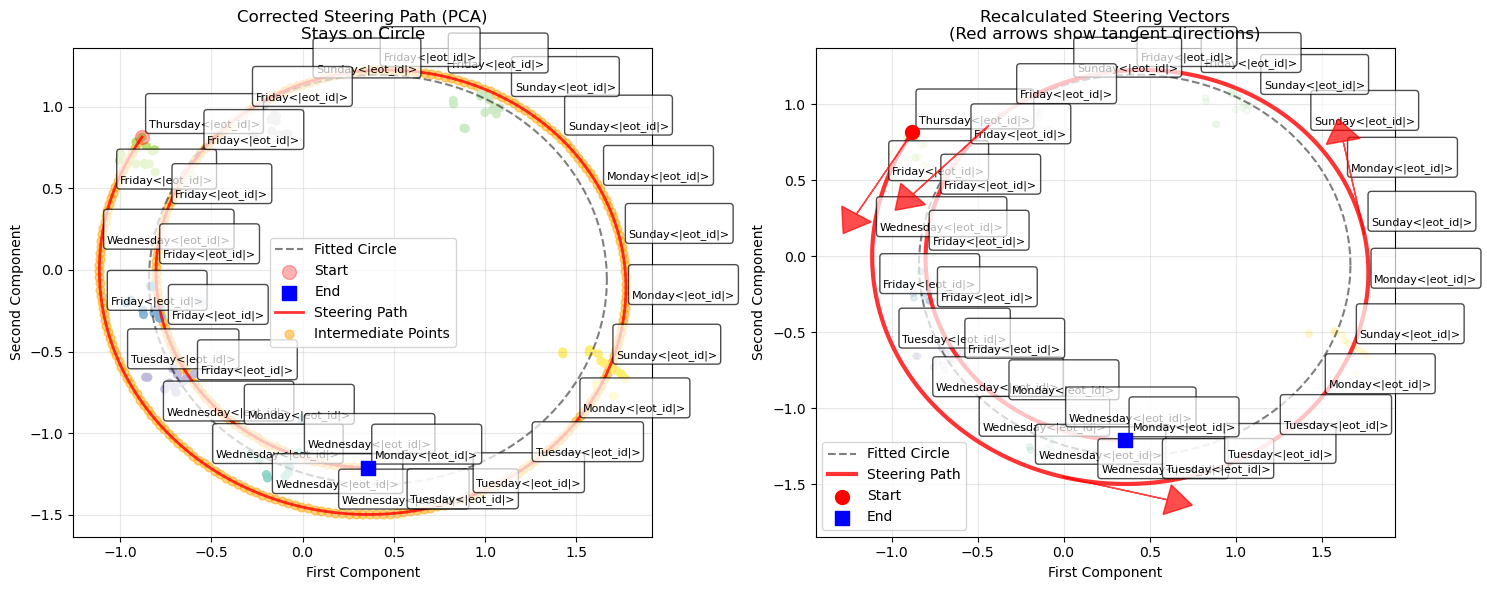

In [814]:

# Initialize steering system
steering = CurvedSteering(activations, df['label'], method='pca')  # or 'kernel_pca'

# Visualize the steering process
steered_points2, steering_info_list = steering.visualize_steering(10, step_size=0.1, direction=1, n_steps=300, text_labels = resampled_generations)

In [807]:
len(steered_points2)

301

In [959]:
def latent_patchify(
    model,
    tokenizer,
    source_activation,
    target_prompt,
    target_token_index,
    target_layer_index,
    max_new_tokens = 10
):

    # Store the specific activation we want to patch
    source_activation_single = torch.tensor(source_activation)
    
    layers = layers = model.model.layers

    
    def patch_hook(module, inp):
        nonlocal source_activation_single, target_token_index
        if inp[0].shape[1] > 1:
            inp[0][:,target_token_index] = source_activation_single
        return inp

    # Forward pass for prompt 2
    messages = [
    {"role": "user", "content": target_prompt},
    ]
    #target_tokens = tokenizer(target_prompt, return_tensors="pt").to(model.device)
    target_tokens = tokenizer.apply_chat_template(messages, return_tensors="pt", return_dict=True).to(model.device)
    #print(target_tokens)

    outputs = model(**target_tokens, output_hidden_states=False, return_dict=False)
    predicted_id = outputs[0].argmax(-1)[:, -1]
    target_tokens_output = tokenizer.decode(predicted_id.squeeze(0).tolist())
    
    # Modified forward pass for prompt 2, patching activation at [target_token_index, target_layer_index]
    hook_p = layers[target_layer_index].register_forward_pre_hook(patch_hook)
    
    outputs = model.generate(**target_tokens, max_new_tokens=max_new_tokens)
    
    target_tokens_patched_output = tokenizer.decode(outputs[0,(target_tokens['input_ids'].shape[1]+4):])

    #outputs = model(**target_tokens, output_hidden_states=False, return_dict=False)
    #predicted_id = outputs[0].argmax(-1)[:, -1]
    #target_tokens_patched_output = tokenizer.decode(predicted_id.squeeze(0).tolist())

    hook_p.remove()

    
    return _ , target_tokens_output, target_tokens_patched_output

In [1012]:
resampled_generations = []
for i in range(len(steered_points)):
    if i%1 == 0:
        
        target_prompt = "Respond only with the answer. Complete the pattern: Man -> Man, Car -> Car,  x -> "
    
        target_token_index = -3
        target_layer_index = layer_no
        
        _, _, response = latent_patchify(
            model,
            tokenizer,
            steered_points[i],
            target_prompt,
            target_token_index,
            target_layer_index,
            max_new_tokens = 5
        )
        
        resampled_generations.append(response)
    


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for

In [998]:
resampled_generations

['Wednesday',
 'Tuesday',
 'Tuesday',
 'Tuesday',
 'Tuesday',
 'Monday',
 'Sunday',
 'Sunday',
 'Sunday',
 'Sunday',
 'Sunday']

In [966]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA, KernelPCA
from sklearn.preprocessing import StandardScaler
from scipy.optimize import minimize

class CurvedSteering2:
    """
    A class for smoothly steering points along the circular cluster path.
    """
    
    def __init__(self, X, y, method='pca', kernel='rbf'):
        """
        Initialize the curved steering system.
        
        Parameters:
        -----------
        X : ndarray
            The dataset
        y : ndarray
            Cluster labels
        method : str
            'pca' or 'kernel_pca'
        kernel : str
            Kernel type if using kernel_pca
        """
        self.X = X
        self.y = y
        self.method = method
        self.kernel = kernel
        
        # Add proper data scaling
        self.scaler = StandardScaler()
        self.X_scaled = self.scaler.fit_transform(X)
        
        # Fit the dimensionality reduction model
        self._fit_projection_model()
        
        # Find the circular structure
        self._find_circular_structure()
    
    def _fit_projection_model(self):
        """Fit PCA or Kernel PCA model."""
        if self.method == 'pca':
            self.projection_model = PCA(n_components=2)
        else:  # kernel_pca
            self.projection_model = KernelPCA(n_components=2, kernel=self.kernel, 
                                            random_state=42, fit_inverse_transform=True)
        
        # Use scaled data for fitting
        self.X_2d = self.projection_model.fit_transform(self.X_scaled)
    
    def _find_circular_structure(self):
        """Find the best-fit circle through cluster centers."""
        # Calculate cluster centers in 2D projection
        unique_labels = np.unique(self.y)
        cluster_centers_2d = []
        
        for label in unique_labels:
            mask = self.y == label
            center = np.mean(self.X_2d[mask], axis=0)
            cluster_centers_2d.append(center)
        
        cluster_centers_2d = np.array(cluster_centers_2d)
        
        # Fit circle to cluster centers
        self.circle_center, self.circle_radius = self._fit_circle(cluster_centers_2d)
        
        print(f"Fitted circle: center=({self.circle_center[0]:.2f}, {self.circle_center[1]:.2f}), radius={self.circle_radius:.2f}")
    
    def _fit_circle(self, points):
        """Fit a circle to a set of 2D points."""
        # Simple circle fitting using least squares
        def calc_radius(center):
            return np.mean(np.sqrt(np.sum((points - center)**2, axis=1)))
        
        def objective(params):
            center = np.array([params[0], params[1]])
            distances = np.sqrt(np.sum((points - center)**2, axis=1))
            radius = np.mean(distances)
            return np.sum((distances - radius)**2)
        
        # Initial guess: centroid of points
        initial_center = np.mean(points, axis=0)
        
        # Simple grid search for circle center
        result = minimize(objective, initial_center, method='BFGS')
        
        center = result.x
        radius = calc_radius(center)
        
        return center, radius
    
    def project_point_to_circle(self, point_idx):
        """
        Project a point to the fitted circle and get its angular position.
        
        Parameters:
        -----------
        point_idx : int
            Index of the point to project
            
        Returns:
        --------
        angle : float
            Angular position on the circle (in radians)
        circle_point_2d : ndarray
            2D coordinates of the projected point on the circle
        """
        # Get 2D projection of the point
        point_2d = self.X_2d[point_idx]
        
        # Vector from circle center to point
        vec_to_point = point_2d - self.circle_center
        
        # Calculate angle
        angle = np.arctan2(vec_to_point[1], vec_to_point[0])
        
        # Project onto circle
        circle_point_2d = self.circle_center + self.circle_radius * np.array([np.cos(angle), np.sin(angle)])
        
        return angle, circle_point_2d
    
    def project_arbitrary_point_to_circle(self, point):
        """
        Project an arbitrary point to the fitted circle.
        
        Parameters:
        -----------
        point : ndarray
            High-dimensional point to project
            
        Returns:
        --------
        angle : float
            Angular position on the circle (in radians)
        circle_point_2d : ndarray
            2D coordinates of the projected point on the circle
        """
        # Scale and project to 2D
        point_scaled = self.scaler.transform(point.reshape(1, -1))
        point_2d = self.projection_model.transform(point_scaled)[0]
        
        # Vector from circle center to point
        vec_to_point = point_2d - self.circle_center
        
        # Calculate angle
        angle = np.arctan2(vec_to_point[1], vec_to_point[0])
        
        # Project onto circle
        circle_point_2d = self.circle_center + self.circle_radius * np.array([np.cos(angle), np.sin(angle)])
        
        return angle, circle_point_2d
    
    def _project_2d_point_to_high_dim(self, point_2d):
        """
        Project a 2D point back to high-dimensional space.
        
        Parameters:
        -----------
        point_2d : ndarray
            Point in 2D space
            
        Returns:
        --------
        point_high_d : ndarray
            Point in original high-dimensional space
        """
        if self.method == 'pca':
            # For PCA: point_high_d = point_2d @ components + mean
            point_scaled = point_2d @ self.projection_model.components_ + self.projection_model.mean_
        else:
            # For Kernel PCA: use inverse_transform
            point_scaled = self.projection_model.inverse_transform(point_2d.reshape(1, -1))[0]
        
        # Inverse scale to get back to original space
        point_high_d = self.scaler.inverse_transform(point_scaled.reshape(1, -1))[0]
        
        return point_high_d
    
    def steer_point_on_circle(self, point_idx, step_size=0.1, direction=1, n_steps=10):
        """
        Steer a point along the circle by performing all operations in 2D space.
        
        Parameters:
        -----------
        point_idx : int
            Index of the point to steer
        step_size : float
            How far to move per step (in radians)
        direction : int
            1 for counterclockwise, -1 for clockwise
        n_steps : int
            Number of steps
            
        Returns:
        --------
        steered_points_high_d : list
            List of steered points in high-dimensional space
        steered_points_2d : list
            List of steered points in 2D space (for visualization)
        angles : list
            List of angles for each steered point
        """
        # Get initial position and project to circle
        initial_angle, initial_circle_point = self.project_point_to_circle(point_idx)
        
        # Generate all angles along the path
        angles = [initial_angle + direction * step_size * i for i in range(n_steps + 1)]
        
        # Generate all 2D points on the circle
        steered_points_2d = []
        for angle in angles:
            circle_point_2d = self.circle_center + self.circle_radius * np.array([np.cos(angle), np.sin(angle)])
            steered_points_2d.append(circle_point_2d)
        
        # Project all points back to high-dimensional space
        steered_points_high_d = []
        for point_2d in steered_points_2d:
            point_high_d = self._project_2d_point_to_high_dim(point_2d)
            steered_points_high_d.append(point_high_d)
        
        return steered_points_high_d, steered_points_2d, angles
    
    def steer_arbitrary_point_on_circle(self, point, step_size=0.1, direction=1, n_steps=10):
        """
        Steer an arbitrary point along the circle.
        
        Parameters:
        -----------
        point : ndarray
            High-dimensional point to steer
        step_size : float
            How far to move per step (in radians)
        direction : int
            1 for counterclockwise, -1 for clockwise
        n_steps : int
            Number of steps
            
        Returns:
        --------
        steered_points_high_d : list
            List of steered points in high-dimensional space
        steered_points_2d : list
            List of steered points in 2D space (for visualization)
        angles : list
            List of angles for each steered point
        """
        # Get initial position and project to circle
        initial_angle, initial_circle_point = self.project_arbitrary_point_to_circle(point)
        
        # Generate all angles along the path
        angles = [initial_angle + direction * step_size * i for i in range(n_steps + 1)]
        
        # Generate all 2D points on the circle
        steered_points_2d = []
        for angle in angles:
            circle_point_2d = self.circle_center + self.circle_radius * np.array([np.cos(angle), np.sin(angle)])
            steered_points_2d.append(circle_point_2d)
        
        # Project all points back to high-dimensional space
        steered_points_high_d = []
        for point_2d in steered_points_2d:
            point_high_d = self._project_2d_point_to_high_dim(point_2d)
            steered_points_high_d.append(point_high_d)
        
        return steered_points_high_d, steered_points_2d, angles
    
    def generate_single_steering_vector(self, point_idx, step_size=0.1, direction=1):
        """
        Generate a single steering vector (for backward compatibility).
        
        Parameters:
        -----------
        point_idx : int
            Index of the point to steer
        step_size : float
            How far to move (in radians)
        direction : int
            1 for counterclockwise, -1 for clockwise
            
        Returns:
        --------
        steering_vector : ndarray
            High-dimensional steering vector
        new_angle : float
            New angular position
        """
        # Get current and next points
        steered_points, _, angles = self.steer_point_on_circle(point_idx, step_size, direction, n_steps=1)
        
        # Steering vector is the difference
        steering_vector = steered_points[1] - steered_points[0]
        new_angle = angles[1]
        
        return steering_vector, new_angle
    
    def visualize_steering(self, point_idx, step_size=0.1, direction=1, n_steps=10, text_labels=None):
        """
        Visualize the steering process with the corrected method.
        
        Parameters:
        -----------
        point_idx : int
            Index of the point to steer
        step_size : float
            How far to move per step
        direction : int
            Direction of movement
        n_steps : int
            Number of steps to visualize
        text_labels : list, optional
            List of text labels to display at each steered point position
        """
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
        
        # Colors for visualization
        colors = plt.cm.Set3(np.linspace(0, 1, len(np.unique(self.y))))
        
        # Get steered points using the corrected method
        steered_points_high_d, steered_points_2d, angles = self.steer_point_on_circle(
            point_idx, step_size, direction, n_steps
        )
        
        steered_points_2d = np.array(steered_points_2d)
        
        # Plot 1: 2D projection showing the circular path
        ax1.scatter(self.X_2d[:, 0], self.X_2d[:, 1], c=[colors[label] for label in self.y], 
                   alpha=0.6, s=30, label='Original Data')
        
        # Draw the fitted circle
        circle_angles = np.linspace(0, 2*np.pi, 100)
        circle_x = self.circle_center[0] + self.circle_radius * np.cos(circle_angles)
        circle_y = self.circle_center[1] + self.circle_radius * np.sin(circle_angles)
        ax1.plot(circle_x, circle_y, 'k--', alpha=0.5, label='Fitted Circle')
        
        # Plot the steering path
        ax1.plot(steered_points_2d[:, 0], steered_points_2d[:, 1], 'r-', 
                linewidth=3, alpha=0.8, label='Steering Path')
        
        # Mark start and end points
        ax1.scatter(steered_points_2d[0, 0], steered_points_2d[0, 1], 
                   c='red', s=120, marker='o', label='Start', zorder=5, 
                   edgecolors='black', linewidth=2)
        ax1.scatter(steered_points_2d[-1, 0], steered_points_2d[-1, 1], 
                   c='blue', s=120, marker='s', label='End', zorder=5,
                   edgecolors='black', linewidth=2)
        
        # Show intermediate points
        if len(steered_points_2d) > 2:
            ax1.scatter(steered_points_2d[1:-1, 0], steered_points_2d[1:-1, 1], 
                       c='orange', s=60, alpha=0.8, label='Intermediate Points', 
                       zorder=4, edgecolors='red')
        
        # Add text labels if provided
        if text_labels is not None:
            for i, point_2d in enumerate(steered_points_2d):
                if i < len(text_labels):
                    ax1.annotate(text_labels[i], (point_2d[0], point_2d[1]), 
                                xytext=(5, 5), textcoords='offset points', 
                                fontsize=9, ha='left', va='bottom',
                                bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.8))
        
        ax1.set_xlabel('First Component')
        ax1.set_ylabel('Second Component')
        #ax1.set_title(f'Corrected Circular Steering ({self.method.upper()})\nPerfectly Follows Circle')
        #ax1.legend()
        ax1.grid(True, alpha=0.3)
        
        # Plot 2: Show the steering vectors as tangents to the circle
        ax2.scatter(self.X_2d[:, 0], self.X_2d[:, 1], c=[colors[label] for label in self.y], 
                   alpha=0.2, s=20, label='Original Data')
        ax2.plot(circle_x, circle_y, 'k--', alpha=0.5, label='Fitted Circle')
        
        # Show tangent vectors at several points along the path
        show_every = max(1, n_steps // 5)  # Show 5-6 tangent vectors max
        for i in range(0, len(steered_points_2d)-1, show_every):
            point_2d = steered_points_2d[i]
            angle = angles[i]
            
            # Tangent vector at this point (perpendicular to radius)
            tangent_2d = np.array([-np.sin(angle), np.cos(angle)]) * direction
            
            # Scale for visibility
            scale_factor = self.circle_radius * 0.3
            ax2.arrow(point_2d[0], point_2d[1], 
                     tangent_2d[0] * scale_factor, 
                     tangent_2d[1] * scale_factor,
                     head_width=0.15, head_length=0.1, fc='red', ec='red',
                     alpha=0.7, zorder=5, linewidth=2)
        
        # Plot the path
        ax2.plot(steered_points_2d[:, 0], steered_points_2d[:, 1], 'r-', 
                linewidth=3, alpha=0.8, label='Steering Path')
        ax2.scatter(steered_points_2d[0, 0], steered_points_2d[0, 1], 
                   c='red', s=120, marker='o', label='Start', zorder=6,
                   edgecolors='black', linewidth=2)
        ax2.scatter(steered_points_2d[-1, 0], steered_points_2d[-1, 1], 
                   c='blue', s=120, marker='s', label='End', zorder=6,
                   edgecolors='black', linewidth=2)
        
        # Add text labels to the second plot as well if provided
        if text_labels is not None:
            for i, point_2d in enumerate(steered_points_2d):
                if i < len(text_labels):
                    ax2.annotate(text_labels[i], (point_2d[0], point_2d[1]), 
                                xytext=(5, 5), textcoords='offset points', 
                                fontsize=9, ha='left', va='bottom',
                                bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.8))
        
        ax2.set_xlabel('First Component')
        ax2.set_ylabel('Second Component')
        #ax2.set_title('Tangent Vectors Along Circle\n(Red arrows show movement direction)')
        ax2.legend()
        ax2.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
        
        return steered_points_high_d, steered_points_2d, angles
    
    def visualize_arbitrary_point_steering(self, point, step_size=0.1, direction=1, n_steps=10, text_labels=None):
        """
        Visualize steering of an arbitrary point using the corrected method.
        
        Parameters:
        -----------
        point : ndarray
            The point to steer
        step_size : float
            How far to move per step
        direction : int
            Direction of movement
        n_steps : int
            Number of steps to visualize
        text_labels : list, optional
            List of text labels for each point
        """
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
        
        # Colors for visualization
        colors = plt.cm.Set3(np.linspace(0, 1, len(np.unique(self.y))))
        
        # Get steered points using the corrected method
        steered_points_high_d, steered_points_2d, angles = self.steer_arbitrary_point_on_circle(
            point, step_size, direction, n_steps
        )
        
        steered_points_2d = np.array(steered_points_2d)
        
        # Plot 1: 2D projection showing the circular path
        ax1.scatter(self.X_2d[:, 0], self.X_2d[:, 1], c=[colors[label] for label in self.y], 
                   alpha=0.6, s=30, label='Original Data')
        
        # Draw the fitted circle
        circle_angles = np.linspace(0, 2*np.pi, 100)
        circle_x = self.circle_center[0] + self.circle_radius * np.cos(circle_angles)
        circle_y = self.circle_center[1] + self.circle_radius * np.sin(circle_angles)
        ax1.plot(circle_x, circle_y, 'k--', alpha=0.5, label='Fitted Circle')
        
        # Show the original arbitrary point and its projection
        point_scaled = self.scaler.transform(point.reshape(1, -1))
        original_2d = self.projection_model.transform(point_scaled)[0]
        
        ax1.scatter(original_2d[0], original_2d[1], c='purple', s=150, marker='*', 
                   label='Original Arbitrary Point', zorder=5, edgecolors='black', linewidth=2)
        
        # Draw line from original point to its circle projection
        ax1.plot([original_2d[0], steered_points_2d[0, 0]], 
                [original_2d[1], steered_points_2d[0, 1]], 
                'purple', linestyle='--', alpha=0.7, linewidth=2, 
                label='Projection to Circle')
        
        # Plot the steering path
        ax1.plot(steered_points_2d[:, 0], steered_points_2d[:, 1], 'r-', 
                linewidth=3, alpha=0.8, label='Steering Path')
        
        # Mark start and end points on circle
        ax1.scatter(steered_points_2d[0, 0], steered_points_2d[0, 1], 
                   c='red', s=120, marker='o', label='Start (On Circle)', zorder=5,
                   edgecolors='black', linewidth=2)
        ax1.scatter(steered_points_2d[-1, 0], steered_points_2d[-1, 1], 
                   c='blue', s=120, marker='s', label='End', zorder=5,
                   edgecolors='black', linewidth=2)
        
        # Add text labels if provided
        if text_labels is not None:
            for i, point_2d in enumerate(steered_points_2d):
                if i < len(text_labels):
                    ax1.annotate(text_labels[i], (point_2d[0], point_2d[1]), 
                                xytext=(5, 5), textcoords='offset points', 
                                fontsize=9, ha='left', va='bottom',
                                bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.8))
        
        ax1.set_xlabel('First Component')
        ax1.set_ylabel('Second Component')
        ax1.set_title(f'Arbitrary Point Circular Steering ({self.method.upper()})\nPerfectly Follows Circle')
        #ax1.legend()
        ax1.grid(True, alpha=0.3)
        
        # Plot 2: Focus on the projection process
        ax2.scatter(self.X_2d[:, 0], self.X_2d[:, 1], c=[colors[label] for label in self.y], 
                   alpha=0.2, s=20, label='Original Data')
        ax2.plot(circle_x, circle_y, 'k--', alpha=0.5, label='Fitted Circle')
        
        # Show the projection process more clearly
        ax2.scatter(original_2d[0], original_2d[1], c='purple', s=150, marker='*', 
                   label='Arbitrary Point', zorder=5, edgecolors='black', linewidth=2)
        ax2.scatter(steered_points_2d[0, 0], steered_points_2d[0, 1], c='red', s=120, 
                   marker='o', label='Projected onto Circle', zorder=5, 
                   edgecolors='black', linewidth=2)
        
        # Draw projection line
        ax2.plot([original_2d[0], steered_points_2d[0, 0]], 
                [original_2d[1], steered_points_2d[0, 1]], 
                'purple', linestyle='--', alpha=0.7, linewidth=2, 
                label='Radial Projection')
        
        # Show the steering path
        ax2.plot(steered_points_2d[:, 0], steered_points_2d[:, 1], 'r-', 
                linewidth=3, alpha=0.8, label='Steering Path')
        
        ax2.set_xlabel('First Component')
        ax2.set_ylabel('Second Component')
        ax2.set_title('Projection Process:\nArbitrary Point → Circle → Steering')
        ax2.legend()
        ax2.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
        
        return steered_points_high_d, steered_points_2d, angles

Fitted circle: center=(-9.71, 3.14), radius=29.26


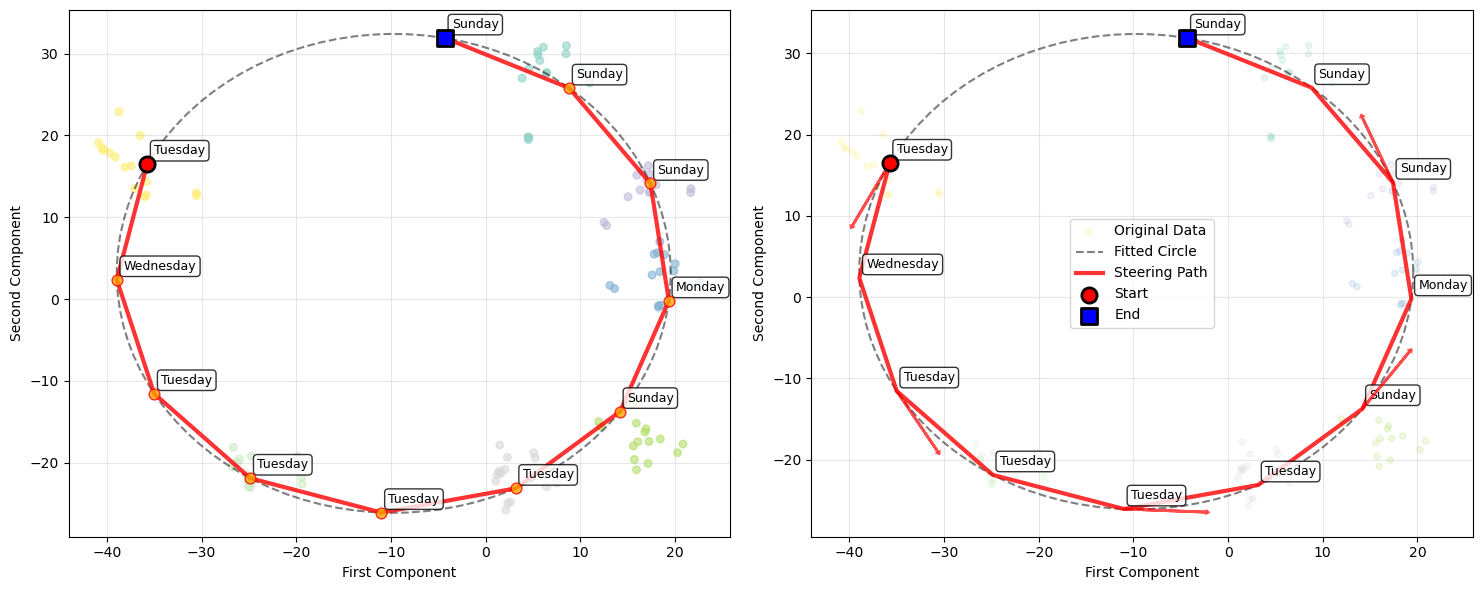

In [1135]:
# Initialize steering system
steering = CurvedSteering2(activations, df['label'], method='pca')  # or 'kernel_pca'

# Visualize the steering process
steered_points, _, _ = steering.visualize_steering(0, step_size=0.5, direction=1, n_steps=10, text_labels = resampled_generations)

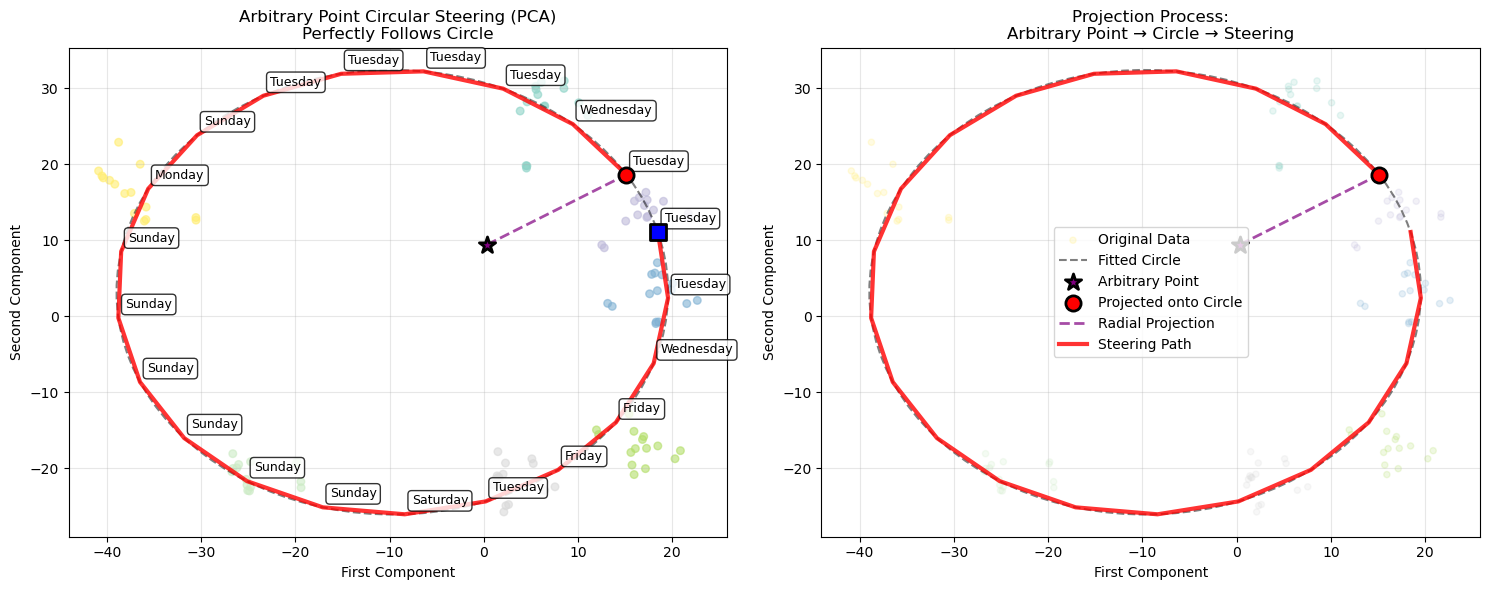

In [1136]:

point = np.array([0.3,0.3]) @ steering.projection_model.components_ + steering.projection_model.mean_
steered_points, _, _ = steering.visualize_arbitrary_point_steering(point, step_size=0.3, direction=1, n_steps=20, text_labels = resampled_generations)

In [1223]:
df2 = pd.DataFrame()
#df2['statement'] = [f"{['2am', '6am', '10am', '2pm', '6pm', '10pm'][i%6]} {['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday'][i//6%7]}" for i in range(42)]
df2['statement'] = [f"{['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday'][i//24%7]} {i%24:02d}:00" for i in range(168)]
df2['label'] = [i % 24 for i in range(168)]
#[i//4 for i in range(28)]
#[f"{['morning', 'afternoon', 'evening', 'night'][i%4]}
df2

,statement,label
0,Sunday 00:00,0
1,Sunday 01:00,1
2,Sunday 02:00,2
3,Sunday 03:00,3
4,Sunday 04:00,4
...,...,...
163,Saturday 19:00,19
164,Saturday 20:00,20
165,Saturday 21:00,21
166,Saturday 22:00,22


In [1225]:
activations_by_layer2 = process_activations(df2[:n_samples], text_column, n_samples, layers)

Processing: 100%|█████████████████████████████| 168/168 [00:05<00:00, 31.83it/s]


In [1226]:
activations2 = activations_by_layer2['model.layers.4.resid']

In [1291]:
#pca = PCA(n_components = 3)
#X = pca.fit_transform(activations)

from sklearn.manifold import Isomap
isomap = Isomap(n_neighbors=15, n_components=2)
X= isomap.fit_transform(activations)

In [1265]:
steering.projection_model.explained_variance_ratio_

array([0.20553696, 0.16942398])

ValueError: s must be a scalar, or float array-like with the same size as x and y

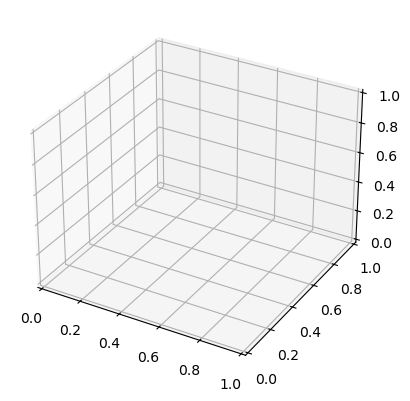

In [1275]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')


ax.scatter(X[:,0], X[:,1], c = df['label'], cmap = 'YlGnBu', edgecolor = 'k', linewidth=0.3)
#ax.scatter(X_new[:,0], X_new[:,1], X_new[:,2], c = df2['label'], cmap = 'OrRd', edgecolor = 'k', linewidth=0.3)


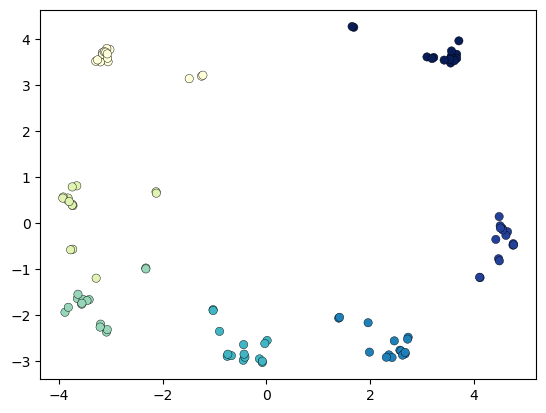

In [1293]:
plt.scatter(X[:,0], X[:,1], c = df['label'], cmap = 'YlGnBu', edgecolor = 'k', linewidth=0.3)
